In [1]:
# imports
import numpy as np
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.circuit.library import TwoLocal
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
 # Save account to disk.
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="cdf9b9daff6e97da8251bab4881ad0e7225af65946ca3f7e127fa3e4709ff8f15e34a8d45aba9936e77fa455b9d426546c6b62dda33b95b996237eb100b43aee", name="xuy", set_as_default=True, overwrite=True)
 
 # Load saved credentials
service = QiskitRuntimeService(name="xuy")

# backend = AerSimulator()
# backend = FakeSherbrooke()
backend = service.backend("ibm_cleveland")

# ### Don't change any code past this line ###

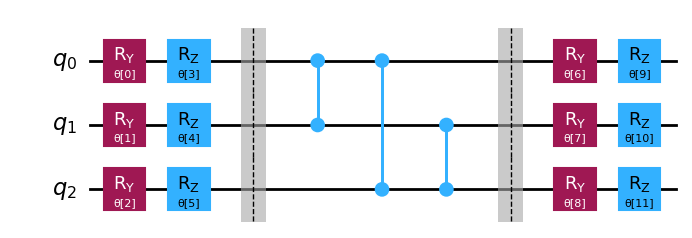

In [3]:
num_qubits = 3 #Add your code here
rotation_blocks = ['ry','rz']#Add your code here
entanglement_blocks = 'cz' #Add your code here
entanglement = 'full' #Add your code here

ansatz = TwoLocal(3, rotation_blocks , entanglement_blocks, entanglement , reps=1, insert_barriers=True) #Add your code here


### Don't change any code past this line ###
ansatz.decompose().draw('mpl')

In [4]:
num_params = ansatz.num_parameters
num_params

12

In [9]:
backend_answer = backend() #Add your code
optimization_level_answer = 2 #Add your code
pm = generate_preset_pass_manager(backend=backend_answer,optimization_level=optimization_level_answer)
isa_circuit = pm.run(ansatz) # Add your code

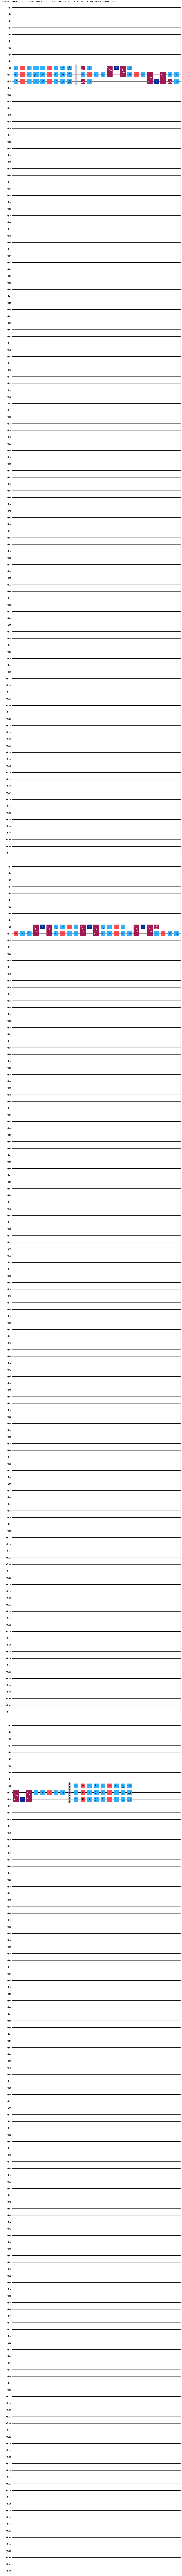

In [10]:
isa_circuit.decompose().draw('mpl')

In [12]:
pauli_op = SparsePauliOp(['ZII', 'IZI', 'IIZ', 'XYZ'])
print(pauli_op.to_matrix())

[[ 3.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-1.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+1.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+1.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.-1.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.-1.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+1.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.-1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -3.+0.j]]


In [13]:
# Define our Hamiltonian
hamiltonian_isa = pauli_op.apply_layout(layout=isa_circuit.layout)

In [14]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([0.19495127, 2.35343356, 1.20102364, 0.55150212, 2.16131441,
       5.03499059, 2.51700105, 0.88848983, 4.33436998, 0.44171159,
       5.9377186 , 5.84860421])

In [15]:
def cost_func(params, ansatz, hamiltonian, estimator, callback_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    # param_dict = dict(zip(ansatz.parameters, params))
    # pub = ansatz.assign_parameters(param_dict)
    
    pub =  (ansatz, [hamiltonian], [params])  #Add your code
    result = estimator.run(pubs=[pub]).result() #Add your code
    energy =  result[0].data.evs[0] #Add your code

    callback_dict["iters"] += 1 #Add your code
    callback_dict["prev_vector"] = params #Add your code
    callback_dict["cost_history"].append(energy) #Add your code


### Don't change any code past this line ###
    print(energy)
    return energy

In [16]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [17]:
# Here we have updated the cost function to return only the energy to be compatible with recent scipy versions (>=1.10)
# def cost_func_2(*args, **kwargs):
#     energy, result = cost_func(*args, **kwargs)
#     return energy

with Session(backend=backend) as session:
    estimator = Estimator(session=session)

    res = minimize(
        cost_func,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
        method="cobyla",
        options={'maxiter': 100})

-1.2884259214815907
-0.6107146051265132
-2.2833952239233692
-1.9425452618563988
-2.2070868737861455
-2.0176242515411946
-2.3393521826288266
-2.3590684825272867
-1.543768530774498
-1.7999599113665614
-2.4874276539744913
-2.362162071866581
-2.2807358000616467
-2.633743888174222
-2.4253949976939837
-2.7884399423827544
-1.8013768074703806
-2.780957758151957
-2.637144767932105
-2.5935272101957607
-2.325556879556556
-2.704866940243229
-2.55792893158762
-2.413586062330065
-2.769264015066918
-2.6606474770385886
-2.6879987904449396
-2.8409400417074693
-2.866759575766933
-2.8174781191648464
-2.7987536382525597
-2.8695941584453655
-2.8317813476309297
-2.8028772047391266
-2.836617458780157
-2.628020892151327
-2.863084898418763
-2.8783429387696273
-2.8199451971148584
-2.8321495509426167
-2.7934731065296017
-2.916312914360219
-2.885197136898488
-2.799300489520019
-2.877565445531852
-2.8068815378838137
-2.7245922101962328
-2.8083124836910662
-2.756665446824597
-2.843935028646567
-2.887160821892337
-2

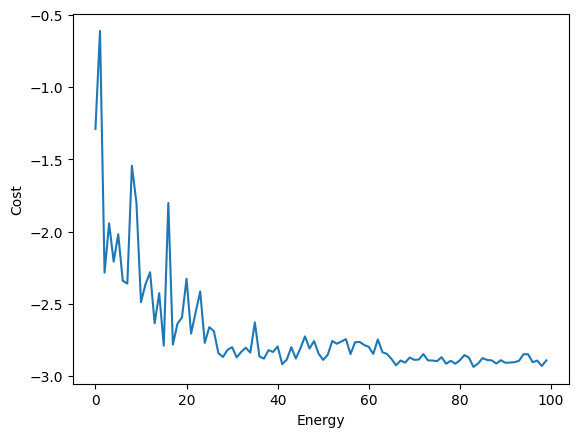

In [18]:
fig, ax = plt.subplots()
plt.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
plt.xlabel("Energy")
plt.ylabel("Cost")
plt.draw()